# Chat bot Text Analysis

In [1]:
import pandas as pd
import numpy as np
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
import datetime
import json
from string import punctuation
import re
import emoji
import itertools
import pickle

# EDA for text libraries
import nltk
import collections
from collections import defaultdict, Counter
from gensim.corpora import Dictionary
import random
import pyLDAvis
pyLDAvis.enable_notebook()
from tqdm.auto import tqdm
#import spacy
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from gensim import models, interfaces, utils
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore


# visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import calendar 
from tabulate import tabulate

# modeling
import nltk
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import statsmodels.tools.tools as stattools
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import seaborn as sns
import plotly.express as px
from sklearn  import metrics
from nltk.corpus import stopwords
from textblob import TextBlob


# Import lexicon and transformer-based sentiment libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)
from transformers import pipeline as tpipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

# Import embedding libraries
from sentence_transformers import SentenceTransformer

# Import vector database (senmantic search) libraries
import pinecone
from pinecone import ApiException

# Import utility libraries
from tqdm import tqdm; tqdm.pandas()
import time


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\afaus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data from csv files:

In [94]:
# Final tool will make the path, filename 
# and session numbers user input variables:

DATA_PATH_chat="./copilot_chat/"
sessions2_df = pd.read_csv(DATA_PATH_chat + 'sessions-2.csv', encoding = "utf-8") #"ISO-8859-1")
sessions3_df = pd.read_csv(DATA_PATH_chat + 'sessions-3.csv', encoding = "utf-8") #"ISO-8859-1")
sessions4_df = pd.read_csv(DATA_PATH_chat + 'sessions-4.csv', encoding = "utf-8") #"ISO-8859-1")

# Set variable to differentiate between sessions/files:
sessions2_df['session']=2
sessions3_df['session']=3
sessions4_df['session']=4

# Combine dataframes into one:
sessions_df = pd.concat([sessions4_df, sessions3_df, sessions2_df])

In [95]:
sessions_df=sessions_df.reset_index()

## Functions Data Clean/Preparation:

In [4]:
# Variable setup for Data Cleaning Functions:

punctuation = set(punctuation) 

whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# adding common wording in chat to stopwords:
sw = stopwords.words("english")
sw = sw + ['nan']
sw = sw + ['said'] + \
          ['news'] + \
          ['us'] + \
          ['dont'] + \
          ['im'] + \
          ['bot'] + \
          ['torero'] + \
          ['help'] + \
          ['says'] + \
          ['say'] + \
          ['hi'] + \
          ['howdy'] + \
          ['Bot says: Hi I\'m _Torero AI'] + \
          ['your go-to helper for any non-academic questions you might have.'] + \
          ['user'] + \
          ['hi']

In [6]:
# Functions:

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text


'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''

def rex_replace(text):

    text = text.replace(r'&nbsp;', ' ').replace(r'-', ' ')\
    .replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ')\
    .replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' ')\
    .replace("AI\u200a_", 'AI')
    return text


def remove_stop(tokens) :
    return[t for t in tokens if t not in sw]


# adding space after certain punctuations to clean
# bot text data for analysis:

def fix_punctuation(text) :
    text = text.replace(r';', '; ').replace(r'?','? ')\
    .replace(r'.','. ').replace(r',',', ')\
    .replace(r':',': ').replace(r'!','! ')
    return text
 
    
def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))


def tokenize(text) : 
    # Splitting on whitespace rather than the book's tokenize function    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
    
def remove_url(text):
    return re.sub(r'http\S+', '', text)


def remove_email(text):
    return(re.sub('\S*@\S+','', text))


def remove_some_text(text): 
    text=text.replace(r' — ', '')\
    .replace(r'**','')\
    .replace(r'[','')\
    .replace(r']','')\
    .replace(r'_','')
    return(re.sub(r'[0-9]', '', text))



In [7]:
# Pipeline Definition 
# and function to implement defined:

# pipeline that removes stopwords for Topic Modeling:
tokenize_sw_pipeline = [rex_replace, remove_url, remove_email,
                     fix_punctuation,remove_punctuation, rex_replace, 
                     remove_some_text, tokenize, remove_stop]

# pipeline that does not remove stopwords
tokenize_pipeline = [rex_replace, remove_url, remove_email,
                     fix_punctuation,remove_punctuation, rex_replace, 
                     remove_some_text, tokenize]

# pipeline to keep context/sentence structures
# for sentiment analysis:
pipeline_basic = [remove_punctuation,remove_url,remove_some_text]
pipeline_basic2 = [remove_url,remove_email,rex_replace,fix_punctuation,remove_some_text]

# pipeline to keep url's and emails/information in
# cleaned up text:
pipeline_basic3 = [rex_replace,fix_punctuation]


# Function to implement pipeline of choice:
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Text Analysis Functions

In [8]:

def get_patterns(text_analyze, num_words):
    if(len(text_analyze)==0):
        raise ValueError("Can't work with empty text object")
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversityP = 0.0
    top_words = []

    total_tokens = len(text_analyze)
    unique_tokens = len(set(text_analyze))
    lexical_diversityP = unique_tokens/total_tokens
    avg_token_len = np.mean([len(ta) for ta in text_analyze])

    top_words_1 = collections.Counter(text_analyze)
    top_words = top_words_1.most_common(num_words)

    results={'tokens': total_tokens,
             'unique_tokens': unique_tokens,
             'avg_token_length': avg_token_len,
             'lexical_diversity': lexical_diversityP,
             'top_words': top_words}
    return(results)


def count_words(x, preprocess=None, min_freq=2, split=0):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    if split == 0:
        counter = collections.Counter(x)
    else: 
        counter = collections.Counter(x.split())
    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'    
    return freq_df.sort_values('freq', ascending=False)


def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], 
                                    abs(words[largest[i]]*100.0/total)))
            
            
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    # filter stop words in frequency counter
    if stopwords is not None:        
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter) 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
        

def split_UserBot(row):
    parts = row.split("Bot says:")
    user_text = parts[0].replace("?;User says:", "").strip()
    bot_text = parts[1].strip() if len(parts) > 1 else ""
    return pd.Series([user_text, bot_text])



## Add text prep columns:

In [96]:
# Various tokenized/cleaned text versions of the ChatTranscript for analysis:

sessions_df['tokens_SA']=sessions_df['ChatTranscript'].apply(prepare,
                                                     pipeline=tokenize_pipeline)

# Used for Topic Analysis:
sessions_df['tokens_TM']=sessions_df['ChatTranscript'].apply(prepare,
                                                     pipeline=tokenize_sw_pipeline)

# Used for Sentiment analysis:
sessions_df['clean_processed_text']=sessions_df['ChatTranscript'].apply(prepare,
                                                                          pipeline = pipeline_basic2)

sessions_df['clean_keepURL_info_text']=sessions_df['ChatTranscript'].apply(prepare,
                                                                          pipeline = pipeline_basic3)

In [97]:
# Word Counts for each record:

sessions_df['original_word_count'] = sessions_df['ChatTranscript'].apply(lambda x: \
                                                                         len(str(x).split(" ")))
sessions_df['token_TM_word_count'] = sessions_df['tokens_TM'].apply(lambda x: \
                                                                         len(str(x).split(" ")))
sessions_df['token_SA_word_count'] = sessions_df['tokens_SA'].apply(lambda x: \
                                                                         len(str(x).split(" ")))

## Distribution charts:

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6')])

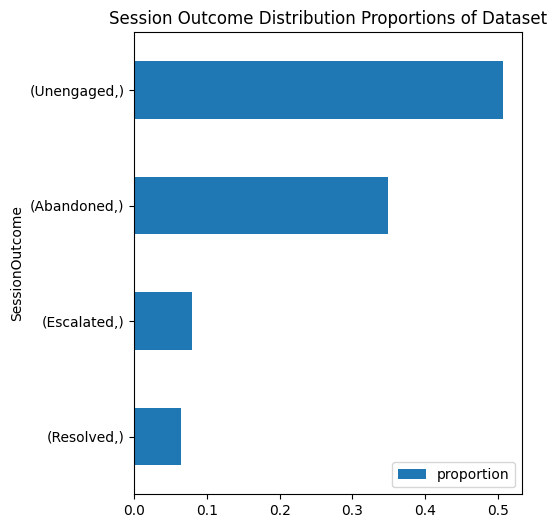

In [11]:
# Overall distribution of Session Outcomes:

sessions_df[['SessionOutcome']].value_counts(normalize=True).sort_values().plot(kind="barh", 
                                  legend=True,
                                  figsize=(5,6),
                                  title='Session Outcome Distribution Proportions of Dataset')
plt.xticks(rotation=0)

In [12]:
# Prep data to chart Session outcomes by session

sessions_spec_s=sessions_df[['SessionOutcome','session']]

s = sessions_df.groupby(['SessionOutcome','session']).size().unstack()
grouped_df = sessions_spec_s['SessionOutcome'].value_counts(normalize=True).sort_values(ascending=[0])
pivot_table = sessions_spec_s.pivot_table(index='SessionOutcome', columns='session', aggfunc=len, fill_value=0)

pivot_table

session,2,3,4
SessionOutcome,,,
Abandoned,0,7,15
Escalated,0,2,3
Resolved,0,2,2
Unengaged,2,6,24


In [13]:
# If we want to know Session Outcomes
# per session proportions

pivot_table_ps = pivot_table
total_len4=sessions4_df.shape[0]
total_len3=sessions3_df.shape[0]
total_len2=sessions2_df.shape[0]

pivot_table_ps[4]=pivot_table_ps[4]/total_len4
pivot_table_ps[3]=pivot_table_ps[3]/total_len3
pivot_table_ps[2]=pivot_table_ps[2]/total_len2

#pivot_table_sent=pivot_table_sent/total_len
pivot_table_ps

session,2,3,4
SessionOutcome,,,
Abandoned,0.0,0.411765,0.340909
Escalated,0.0,0.117647,0.068182
Resolved,0.0,0.117647,0.045455
Unengaged,1.0,0.352941,0.545455


In [14]:
# If we want to know Session Outcomes
# for overall proportions:

total_len=sessions_df.shape[0]
pivot_table_op=pivot_table/total_len
pivot_table_op

session,2,3,4
SessionOutcome,,,
Abandoned,0.000000,0.006536,0.005411
Escalated,0.000000,0.001867,0.001082
Resolved,0.000000,0.001867,0.000722
Unengaged,0.015873,0.005602,0.008658


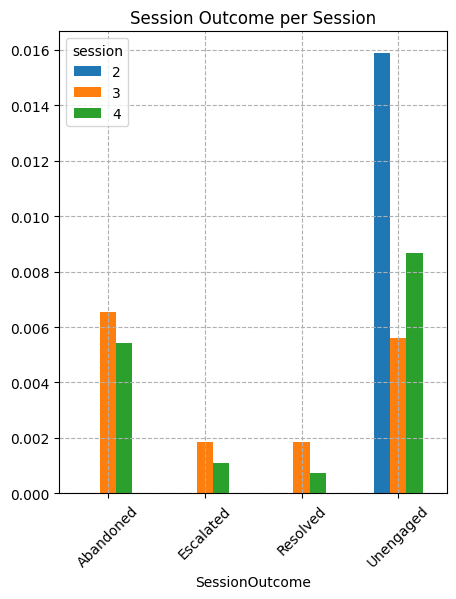

In [15]:
# chart overall Session Outcome
# taking into account the overall
# proportions of occurences:

pivot_table_op.plot(kind="bar",
                                  stacked=False,
                                  legend=True,
                                  figsize=(5,6),
                                  title='Session Outcome per Session')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--')

## Word Count distributions:

[Text(0.5, 1.0, 'Number of Tokens for Cleaned/Tokenized Processed Text without Stop Words')]

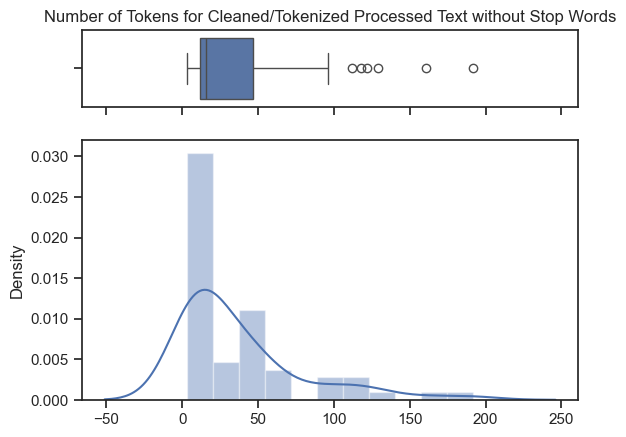

In [16]:
# Boxplot and distribution of word counts
# for text that has been cleaned, tokenized,
# url and emails removed, and stop
# words removed:

sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .85)})
sns.boxplot(x=sessions_df['token_TM_word_count'], ax=ax_box)
sns.distplot(x=sessions_df['token_TM_word_count'], ax=ax_hist)
ax_box.set(title='Number of Tokens for Cleaned/Tokenized Processed Text without Stop Words')


[Text(0.5, 1.0, 'Number of Tokens for Cleaned/Tokenized Processed Text with Stop Words')]

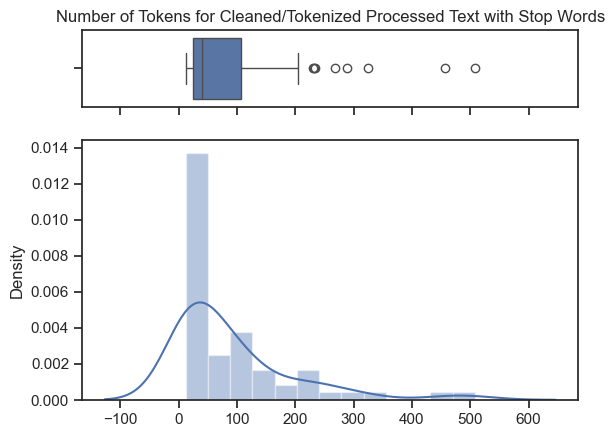

In [17]:
# Boxplot and distribution of word counts
# for text that has been cleaned, tokenized,
# urls and emails removed, and stop
# words were included:

sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .85)})
sns.boxplot(x=sessions_df['token_SA_word_count'], ax=ax_box)
sns.distplot(x=sessions_df['token_SA_word_count'], ax=ax_hist)
ax_box.set(title='Number of Tokens for Cleaned/Tokenized Processed Text with Stop Words')

[Text(0.5, 1.0, 'Number of Words in Original ChatTranscript Text')]

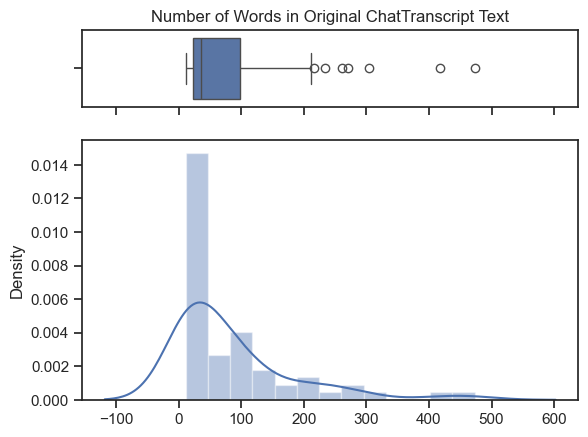

In [18]:
# Boxplot and distribution of word counts
# for original Chat Transcript text

sns.set(style="ticks")

x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.25, .85)})
sns.boxplot(x=sessions_df['original_word_count'], ax=ax_box)
sns.distplot(x=sessions_df['original_word_count'], ax=ax_hist)
ax_box.set(title='Number of Words in Original ChatTranscript Text')

In [19]:
# Descriptive statistics for data:

sessions_df.describe()

,TopicName,TopicId,session,original_word_count,token_TM_word_count,token_SA_word_count
count,0.0,0.0,63.000000,63.000000,63.000000,63.000000
mean,NaN,NaN,3.666667,84.984127,37.000000,91.730159
std,NaN,NaN,0.538816,98.907336,41.286958,105.660779
min,NaN,NaN,2.000000,11.000000,3.000000,12.000000
25%,NaN,NaN,3.000000,22.000000,12.000000,25.000000
50%,NaN,NaN,4.000000,36.000000,16.000000,41.000000
75%,NaN,NaN,4.000000,98.500000,46.500000,106.500000
max,NaN,NaN,4.000000,473.000000,192.000000,508.000000


## Word Clouds:

In [20]:
Text_Words=[token for sublist in
           sessions_df['tokens_TM'] 
           for token in sublist]
Text_Words_counts = collections.Counter(Text_Words)

In [21]:
print("\nChat Transcript Cleaned with stop word removal top 20 words:\n")
for HT, count in Text_Words_counts.most_common(20):
    print(f"{HT}: {count}")


Chat Transcript Cleaned with stop word removal top 20 words:

parking: 79
information: 76
anything: 68
regarding: 66
charges: 66
: 63
else: 61
best: 54
option: 51
go: 49
academic: 49
questions: 49
ai: 48
helper: 48
non: 48
might: 48
bellow: 48
describes: 48
undergraduate: 46
find: 43


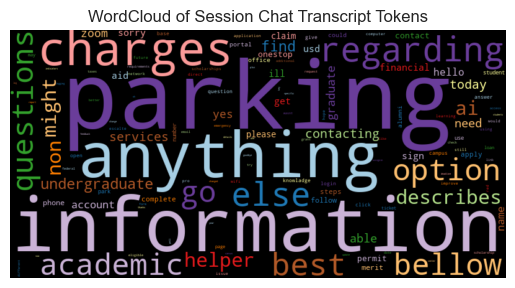

In [22]:
Text_Words_counts2 = count_words(Text_Words, split=0)
wordcloud(Text_Words_counts2['freq'], title="WordCloud of Session Chat Transcript Tokens", max_words=500)

## Topic Modeling:

In [98]:
tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=7, max_df=0.8, ngram_range=(1,1))
topic_modeling_input = tfidf_topic.fit_transform(sessions_df['clean_processed_text'])

In [99]:
# Developing the model based on human observation of topics
# data available is too small to know really how many topics 
# should be used...

nmf_text_model_chat = NMF(n_components=4, random_state=314)
text_matrix = nmf_text_model_chat.fit_transform(topic_modeling_input)
H_text_matrix = nmf_text_model_chat.components_

In [100]:
text_matrix

array([[3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.46840265e-02, 0.00000000e+00, 0.00000000e+00, 5.87500926e-01],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.24434276e-02, 0.00000000e+00, 0.00000000e+00, 6.18201012e-01],
       [1.28935975e-01, 0.00000000e+00, 0.00000000e+00, 5.50774658e-01],
       [5.56036972e-02, 3.37233902e-02, 0.00000000e+00, 6.13526868e-01],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.20814650e-01],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.55011970e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.09724774e-01],
       [0.00000000e+00, 3.97709477e-01, 0.00000000e

In [101]:
display_topics(nmf_text_model_chat, tfidf_topic.get_feature_names_out())


Topic 00
  best (7.89)
  option (7.80)
  academic (7.80)
  go (7.79)
  questions (7.77)

Topic 01
  anything (23.33)
  else (21.84)
  zoom (4.92)
  account (4.66)
  yes (4.25)

Topic 02
  able (21.96)
  need (21.92)
  sign (20.13)
  hello (19.28)
  undergraduate (2.42)

Topic 03
  parking (15.91)
  information (12.81)
  undergraduate (8.22)
  find (7.88)
  charges (7.66)


In [102]:
topic_names = []
voc=tfidf_topic.get_feature_names_out()
for topic in nmf_text_model_chat.components_:
    important = topic.argsort()
    top_word=voc[important[-1]] + " " + voc[important[-2]] + " " + voc[important[-3]]
    topic_names.append(top_word)

In [103]:
topic_names

['best option academic',
 'anything else zoom',
 'able need sign',
 'parking information undergraduate']

In [109]:
#topic_ = defaultdict(list)
sessions_df["topic_name"]="None"
sessions_df["topic"]=999

for idx, row in enumerate(text_matrix) : 
    topic3 = np.where(row == np.amax(row))[0]
    in_order =row.argsort()
    #print(topic3[0])
    sessions_df.loc[idx,"topic"]=topic3[0]
    sessions_df.loc[idx,"topic_name"]=topic_names[topic3[0]]


In [111]:
sessions_df.tail()

,index,SessionId,StartDateTime(UTC),InitialUserMessage,TopicName,ChatTranscript,SessionOutcome,TopicId,session,tokens_SA,tokens_TM,clean_processed_text,clean_keepURL_info_text,original_word_count,token_TM_word_count,token_SA_word_count,topic_name,topic
58,14,50e35f95-58cb-4459-af26-ca95cd4ee7e0-50e35f95-...,2/8/2024 8:26:08 PM,Graduate,NaN,Bot says: Hi User name here I'm _Torero AI _ ...,Abandoned,NaN,3,"[bot, says, hi, user, name, here, im, torero, ...","[name, ai, go, helper, non, academic, question...",Bot says: Hi User name here I'm Torero AI y...,Bot says: Hi User name here I'm _Torero AI _...,98,47,106,anything else zoom,1
59,15,729b8439-5a1b-4fda-a714-a9fcfbaf6bcc-729b8439-...,2/8/2024 8:34:00 PM,Undergraduate,NaN,Bot says: Hi User name here I'm _Torero AI _ ...,Unengaged,NaN,3,"[bot, says, hi, user, name, here, im, torero, ...","[name, ai, go, helper, non, academic, question...",Bot says: Hi User name here I'm Torero AI y...,Bot says: Hi User name here I'm _Torero AI _...,36,16,41,best option academic,0
60,16,d53f49d8-991f-4dba-935d-270a3a70fd09-d53f49d8-...,2/8/2024 8:40:00 PM,NaN,NaN,Bot says: Hi User name here I'm _Torero AI _ ...,Unengaged,NaN,3,"[bot, says, hi, user, name, here, im, torero, ...","[name, ai, go, helper, non, academic, question...",Bot says: Hi User name here I'm Torero AI y...,Bot says: Hi User name here I'm _Torero AI _...,25,13,28,best option academic,0
61,0,17528cef-4e3c-46a1-b5d4-276e23c5a3fe-17528cef-...,2/9/2024 1:13:08 AM,NaN,NaN,Bot says: Hi User name here I'm _Torero AI _ ...,Unengaged,NaN,2,"[bot, says, hi, user, name, here, im, torero, ...","[name, ai, go, helper, non, academic, question...",Bot says: Hi User name here I'm Torero AI y...,Bot says: Hi User name here I'm _Torero AI _...,25,13,28,best option academic,0
62,1,9WTUYiO7jr25fE8ikq17ee-us-9WTUYiO7jr25fE8ikq17...,2/9/2024 2:18:46 AM,NaN,NaN,Bot says: Hello! To be able to help you I'll n...,Unengaged,NaN,2,"[bot, says, hello, to, be, able, to, help, you...","[hello, able, ill, need, sign, ]",Bot says: Hello! To be able to help you I'll...,Bot says: Hello! To be able to help you I'll...,15,6,16,able need sign,2


In [112]:
topics_overall = sessions_df['topic_name'].value_counts(normalize=True)
display(topics_overall)

topic_name
best option academic                 0.285714
anything else zoom                   0.269841
able need sign                       0.238095
parking information undergraduate    0.206349
Name: proportion, dtype: float64

In [113]:
topics_overall_df=pd.DataFrame(topics_overall)
topics_overall_df.head()

,proportion
topic_name,
best option academic,0.285714
anything else zoom,0.269841
able need sign,0.238095
parking information undergraduate,0.206349


In [114]:
topics_overall_df['proportion']=round(topics_overall_df['proportion'],4)
topics_overall_df=topics_overall_df.sort_values('proportion', ascending=True)

[Text(0, 0, '0.2063'),
 Text(0, 0, '0.2381'),
 Text(0, 0, '0.2698'),
 Text(0, 0, '0.2857')]

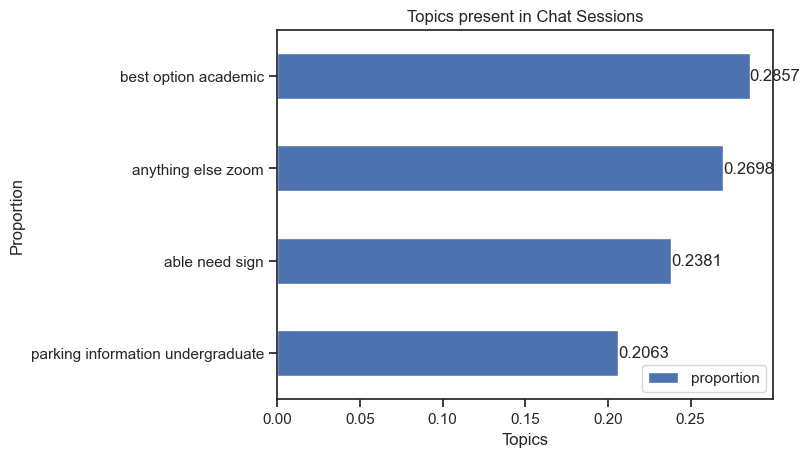

In [115]:
#topics_overall.

ax4=topics_overall_df['proportion'].plot(kind="barh", x='topic_name',rot=0,
                                  legend=True,
                                  #figsize=(8,12),
                                  xlabel='Topics',
                                  ylabel='Proportion',
                                  #='Political_Lean',
                                  title='Topics present in Chat Sessions')
ax4.bar_label(ax4.containers[0])

<Figure size 2500x700 with 0 Axes>

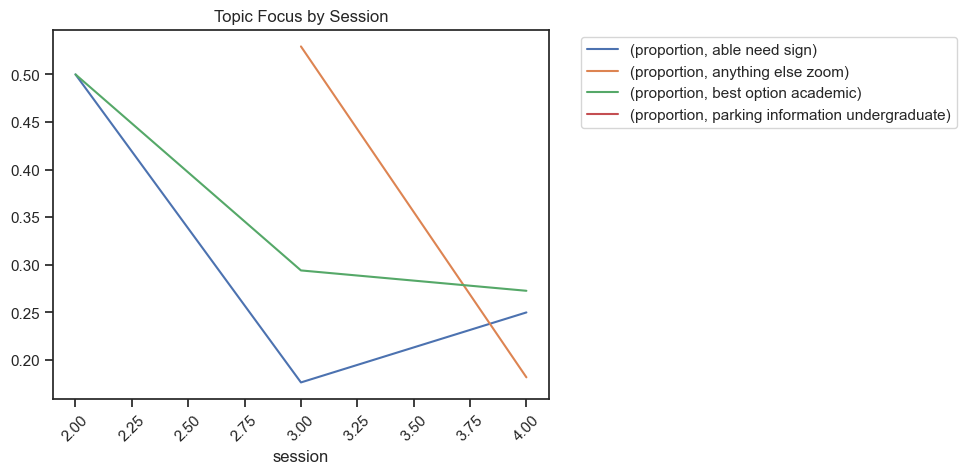

<Figure size 2500x700 with 0 Axes>

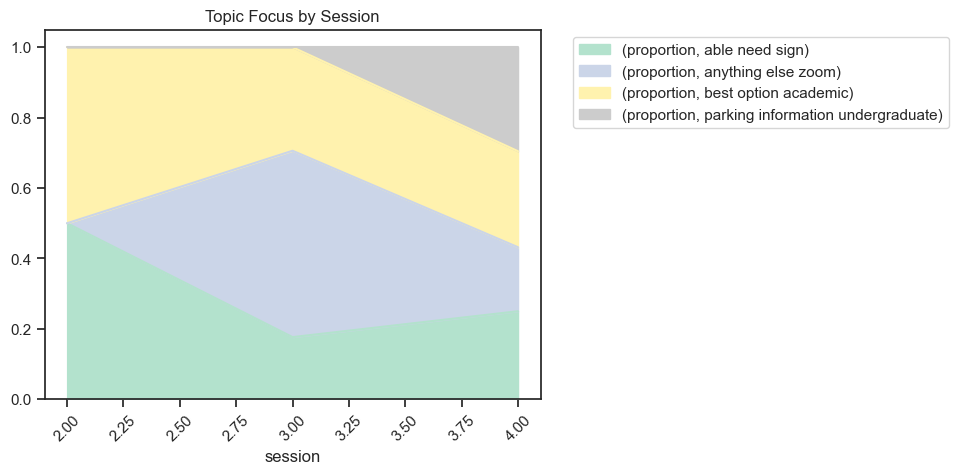

<Figure size 2500x700 with 0 Axes>

In [116]:

df_day1=sessions_df[['session', 'topic_name']]
topics_by_date=df_day1.groupby(df_day1['session']).value_counts(normalize=True)

topics_by_date.head()


df_day=pd.DataFrame(topics_by_date)#.set_index(0)
df_day.head(20)
dfg = df_day.groupby(['session', 'topic_name']).agg({'proportion': sum}).reset_index()
dfg.head()
df = dfg.set_index(['session', 'topic_name']).unstack()
df.plot()
plt.title('Topic Focus by Session')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.figure(figsize=(25, 7))


df.plot.area(colormap="Pastel2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.title('Topic Focus by Session')
plt.figure(figsize=(25, 7))

## Sentiment Analysis:

In [59]:
# Create class instance analyzer for VADER sentiment
sid = SentimentIntensityAnalyzer()

# Classification category function
def classify_sentiment(score):
    if score < -0.3:
        return 'negative'
    elif score > 0.3:
        return 'positive'
    else:
        return 'neutral'    
    
    
# Apply VADER sentiment
sessions_df['sentiment_vader'] =\
    sessions_df['clean_processed_text'].progress_apply(lambda text: sid.polarity_scores(text))
sessions_df['sentiment_vader_compound'] =\
    sessions_df['sentiment_vader'].progress_apply(lambda d: d['compound'])
sessions_df['sentiment_vader_cat'] =\
    sessions_df['sentiment_vader_compound'].progress_apply(classify_sentiment)

# Persist dataframe with sentiments (so don't need to re-run)
print(f'Writing={len(sessions_df)}')
subset_df = sessions_df[['SessionId',
                        'sentiment_vader', 'sentiment_vader_compound', 'sentiment_vader_cat']]
subset_df.to_csv('./session_SA.csv', index=False)
print(f'Written={len(subset_df)}')

# Summarize sentiment by 'source_name' for analysis by source
grouped_sentiment = sessions_df.groupby('session')['sentiment_vader_cat'].value_counts()
print(grouped_sentiment.to_string(max_rows=None))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<?, ?it/s]

Writing=63
Written=63
session  sentiment_vader_cat
2        positive                2
3        positive               17
4        positive               43
         negative                1


In [58]:
sessions_df.iloc[12]['ChatTranscript']

"Bot says: Hi I'm _Torero AI\u200a_ your go-to helper for any non-academic questions you might have. What option bellow best describes you?;User says: Graduate;Bot says: Howdy! **Graduate** how can I help you today?;User says: Where can I park?;Bot says: You can find information about parking by contacting Parking Services at (619) 260-4518 or parking@sandiego.edu [1].[1]: https://usdkb.sandiego.edu/s/article/Information-Regarding-Other-Charges Information Regarding Other Charges;Bot says: Is there anything else I can help you with?;User says: Yes;Bot says: You can find information about parking by contacting Parking Services at (619) 260-4518 or parking@sandiego.edu [1].[1]: https://usdkb.sandiego.edu/s/article/Information-Regarding-Other-Charges Information Regarding Other Charges;Bot says: You can find information about parking by contacting Parking Services at (619) 260-4518 or parking@sandiego.edu [1].[1]: https://usdkb.sandiego.edu/s/article/Information-Regarding-Other-Charges In

In [60]:
sessions_sent_s=sessions_df[['sentiment_vader_cat','session']]
s_sent = sessions_df.groupby(['sentiment_vader_cat','session']).size().unstack()

pivot_table_sent = sessions_sent_s.pivot_table(index='sentiment_vader_cat', columns='session', aggfunc=len, fill_value=0)
pivot_table_sent

session,2,3,4
sentiment_vader_cat,,,
negative,0,0,1
positive,2,17,43


In [61]:
total_len=sessions_df.shape[0]
total_len4=sessions4_df.shape[0]
total_len3=sessions3_df.shape[0]
total_len2=sessions2_df.shape[0]

pivot_table_sent[4]=pivot_table_sent[4]/total_len4
pivot_table_sent[3]=pivot_table_sent[3]/total_len3
pivot_table_sent[2]=pivot_table_sent[2]/total_len2

#pivot_table_sent=pivot_table_sent/total_len
pivot_table_sent

session,2,3,4
sentiment_vader_cat,,,
negative,0.0,0.0,0.022727
positive,1.0,1.0,0.977273


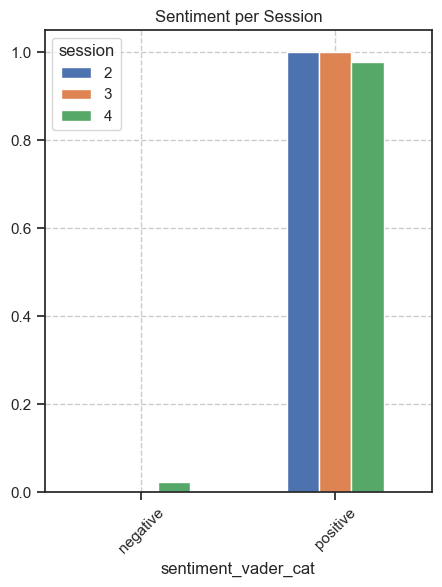

In [62]:
pivot_table_sent.plot(kind="bar",
                                  stacked=False,
                                  legend=True,
                                  figsize=(5,6),
                                  title='Sentiment per Session')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--')